# `BoXHED2.0` tutorial
`BoXHED2.0` (https://arxiv.org/pdf/2103.12591.pdf) is a software package for estimating hazard functions nonparametrically via gradient boosting.

This tutorial demonstrates how to apply `BoXHED2.0` to a synthetic dataset.

Please refer to the paper above for the basics of time-dependent survival data.

In [1]:
import os
import pandas as pd
from boxhed.boxhed import boxhed
from boxhed.model_selection import cv, best_param_1se_rule
from boxhed.utils import timer

In [2]:
DATA_ADDRESS = "./data/"    # directory containing the synthetic training and test data

## Required format for training data
A `pandas` dataframe with the following columns:
* ID:      subject ID
* $t_{start}$: the start time of an epoch for the subject
* $t_{end}$:   the end time of the epoch
* $X_i$:       values of covariates between $t_{start}$ and $t_{end}$
* $\delta$:    equals 1 if an event (possibly recurring) occurred at $t_{end}$; 0 otherwise

Sample output from synthetic training data:

    ID      t_start       t_end         X_0          delta
    1       0.010000      0.064333      0.152407	 0
    1       0.064333      0.135136	  0.308475	 0
    1       0.194810	  0.223106	  0.614977	 1
    1       0.223106	  0.248753	  0.614977	 0
    2       0.795027	  0.841729	  0.196407	 1
    2       0.841729	  0.886587	  0.196407	 0
    2       0.886587	  0.949803      0.671227	 0 

* For each epoch (row) we must have $t_{start} < t_{end}$. Also, the beginning of one epoch cannot start earlier than the end of the previous one, i.e. $t_{end,i} \le t_{start,i+1}$.
* For covariates with missing values, `BoXHED2.0` implements tree splits of the form:

$$\text{Left daughter node: } \{x\le \text{split.point or $x$ is missing}\}; \qquad \text{Right daughter node: } \{x>\text{split.point}\}$$

or

$$\text{Left daughter node: } \{x\le \text{split.point}\}; \qquad \text{Right daughter node: } \{x>\text{split.point or $x$ is missing}\}$$

Alternatively, missing values may be manually imputed, e.g. by carrying forward the most recent value.

In [3]:
train_data = pd.read_csv(os.path.join(DATA_ADDRESS, 'training.csv'))

## Test data points
A `pandas` dataframe where each row consists of a point $(t,x_0,x_1,\cdots)$ where we want to evaluate the estimated `BoXHED` hazard function $\hat\lambda(t,x_0,x_1,\cdots)$.

In [4]:
test_X = pd.read_csv(os.path.join(DATA_ADDRESS, 'testing.csv'))

## Preprocessing the training data
`BoXHED2.0` applies a preprocessing trick to the training data to speed up training (see Section 3.3 of the `BoXHED2.0` paper). **THE DATA ONLY NEEDS TO BE PREPROCESSED ONCE PER TRAINING SET**. `BoXHED2.0` does not use the original training data, just the outputs from the `boxhed.preprocess()` function.

#### Inputs for `boxhed.preprocess()`:
* `num_quantiles`: the number of candidate split points to try for time and for each covariate.

The locations of the split points are based on the quantiles of the training data. The default value is 256. Some applications may need finer splits and therefore a larger value.
   
* `is_cat`: a list of the column indexes that contain categorical data. The categorical data must be one-hot encoded. For example, `is_cat`=[4,5,6] if a categorical variable with 3 factors is transformed into binary-valued columns 4,5,6.
* `split_vals`: To specify custom candidate split points for time and/or a subset of covariates, use a dictionary to specify the values to split on (details below). Candidate split points for time/covariates not specified in `split_vals` will be chosen in accordance to the `num_quantiles` option above.

For specifying candidate split points for time, the dictionary key should be "t", and the dictionary value should be a list (or a 1d `NumPy` array) containing candidate split points. For covariates, the key should match the column name in the dataset. Key values "ID", "t_start", "t_end", and "delta" are not allowed. Do not specify more split points than `num_quantiles`.
     
* `weighted`: if set to True, the locations of the candidate split points will be based on weighted quantiles (see Section 3.4 of the `BoXHED2.0` paper)

* `nthreads`: number of CPU threads to use for preprocessing the data.

#### Outputs for `boxhed.preprocess()`:
* `ID`:            subject ID for each row in the processed data frames `X`, `w`, and `delta`.
* `X`:             each row represents an epoch of the transformed data, and contains the values of the covariates as well as its start time.
* `w`:             length of each epoch.    
* `delta`:         equals one if an event occurred at the end of the epoch; zero otherwise.

In [5]:
train_info_dict = {}                          # Define the output dictionary
boxhed_ = boxhed()                            # Create an instance of BoXHED
prep_timer = timer()                          # Initialize timer

X_post                = boxhed_.preprocess(
        data          = train_data, 
        #is_cat       = [],
        #split_vals   = {"t": [0.2, 0.4, 0.6, 0.8]},
        num_quantiles = 256, 
        weighted      = False, 
        nthread       = -1)                          # number of CPU threads to use. Set to -1 to use all available threads
train_info_dict["prep_time"] = prep_timer.get_dur()  # time taken to preprocess the training data

## Tuning hyperparameters by $K$-fold cross-validation
Like other gradient boosting algorithms, the main `BoXHED` hyperparameters that need to be tuned are
- the depth of each boosted tree `max_depth`; and
- the number of trees `n_estimators`.
    
We use $K$-fold cross-validation and the one-standard-error rule to determine the best hyperparameter combination to use.

We proceed in two steps. First, for each {`max_depth`, `n_estimators`} combination specified by the user, the `cv()` function is used to obtain the $K$-fold mean and standard error for the associated log-likelihood value. The folds are split by subject ID. For this example, the output `cv_rslts` from `cv()` can be expressed in the tabular form (standard errors in parentheses):
         
          n_estimators     50              100             150             200             250             300
    max_depth 
      1                    -519.44(2.02)   -499.18(3.12)   -495.56(3.79)   -494.54(4.10)   -494.86(4.38)   -494.93(4.56)         
      2                    -497.64(3.75)   -496.91(4.36)   -499.72(4.73)   -501.67(4.83)   -504.25(4.75)   -505.13(4.76)
      3                    -498.65(4.65)   -503.33(5.37)   -511.76(5.46)   -519.42(5.62)   -521.32(5.96)   -521.32(5.96)
      4                    -506.26(4.84)   -517.03(6.79)   -530.36(8.48)   -539.09(8.82)   -543.24(10.24)  -543.98(10.61)
      5                    -509.96(7.19)   -526.62(7.81)   -547.40(12.84)  -562.12(13.90)  -566.06(13.84)  -566.50(13.79)

#### Inputs for `cv()`:
* `param_grid`: the set of hyperparameters to try (see code below for example).
* `X`, `w`, `delta`, `ID`: the processed data output from `boxhed.preprocess()`.
* `num_folds`: the number $K$ in $K$-fold cross-validation.
* `gpu_list`: the list of GPU IDs to use for training. Set `gpu_list`=[-1] to use CPUs.
* `nthreads`: if training with CPUs, this is the number of threads to use. Default is -1 (use all available threads).
* `models_per_gpu`: number of instances to train on each GPU.

For example, performing 10-fold cross-validation on 30 different {`max_depth`, `n_estimators`}-hyperparameter combinations requires training 10$\times$30=300 instances in total. If using GPUs, setting `models_per_gpu`=5 would mean that each GPU will train at most 5 instances at a time. The right `models_per_gpu` value to use will require some exploration, as it depends on the problem size and GPU memory.

#### Output for `cv()`:
* `cv_rslts`: the $K$-fold mean and standard error of the log-likelihood value for each hyperparameter combination.       

In [6]:
num_folds = 5

#The set of hyperparameters to cross-validate on (more trees and/or deeper trees may be needed for other datasets)
param_grid = {
        'max_depth':    [1, 2, 3, 4, 5],                 #a tree of depth k has 2^k leaf nodes
        'n_estimators': [50, 100, 150, 200, 250, 300],   #number of trees in the boosted ensemble
        'eta':          [0.1]                            #stepsize shrinkage, usually held fixed at a small number
    }

gpu_list = [-1]   # if training with CPU cores
#gpu_list = [0]   # if training with the first GPU
#gpu_list = [0,1] # if training with the first 2 GPUs etc.

  
cv_timer = timer()
cv_rslts = cv(param_grid, 
              X_post,
              num_folds,
              gpu_list,
              nthread = -1,        #-1 means use all available CPU threads if training with CPU 
              models_per_gpu = 1)  #the right number to use for a specific problem will require some exploration

train_info_dict["CV_time"] = cv_timer.get_dur() #time taken to perform K-fold cross-validation

batched cross validation: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it]


From the tabular form of `cv_rslts` above, the mean log-likelihood is maximized at {`max_depth`=1, `n_estimators`=200} with value $-494.54$. However, the *one-standard-error rule* ($\S$7.10 in 'Elements of Statistical Learning' by Hastie et al. (2009)) suggests choosing the 'simplest model' whose mean log-likelihood is no less than 1 standard error from the maximum. In other words, choose the simplest model whose mean log-likelihood is no less than $-494.54-4.10 = -498.64$. The hyperparameters with mean log-likelihood larger than this are:

          n_estimators     50              100             150             200             250             300
    max_depth 
      1                                                    -495.56         -494.54         -494.86         -494.93
      2                    -497.64         -496.91
      3               
      4               
      5               

There is no generally accepted way to compare the complexities of these choices against one another. One heuristic is to define the complexity of a hyperparameter combination as

$$\text{n_estimators}\times 2^\text{max_depth}.$$

Under this criterion, {`max_depth`=2, `n_estimators`=50} has the lowest complexity, and is hence the most parsimonious choice. However, if we only consider hyperparameters with `max_depth`$\le$1 and `n_estimators`$\le$200, then {`max_depth`=1, `n_estimators`=150} is the most parsimonious.

In the second step of hyperparameter tuning below, we allow the user to define a custom `model_complexity()` function. The `best_param_1se_rule()` implements the one-standard-error rule for choosing the hyperparameter combination to use for fitting `BoXHED2.0`.

#### Inputs for `best_param_1se_rule()`:
* `cv_rslts`: the output from the $K$-fold cross-validation step above.
* `model_complexity`: user-defined function for measuring the complexity a particular hyperparameter combination. If none is provided, the default is $\text{n_estimators}\times 2^\text{max_depth}$.
* `bounded_search`: In this example, the hyperparameter combination maximizing the mean log-likelihood is {`max_depth`=1, `n_estimators`=200}. If this option is True (the default), then any combination with `max_depth`>1 or `n_estimators`>200 trees will be discarded.

#### Outputs for `best_param_1se_rule()`:
* `best_params`: the hyperparameter combination for the most parsimonious model.
* `params_within_1se`: the list of all hyperparameter combinations whose mean log-likelihood is within 1 standard error of that of the best performing combination.

In [7]:
#user-defined measure of model complexity
def model_complexity(max_depth, n_estimators):
    return n_estimators*(2**max_depth)


cv_timer = timer()
best_params, params_within_1se = best_param_1se_rule(cv_rslts,
                                                     model_complexity,      #If none is provided, defaults to the example above
                                                     bounded_search=True)   #default is True

train_info_dict["CV_time"] += cv_timer.get_dur()   #update to total time taken to tune hyperparameters

print (best_params) # Print chosen hyperparameters

{'max_depth': 1, 'n_estimators': 150}


## Fitting `BoXHED2.0` to training data
Fit the hazard function using the cross-validated hyperparameters chosen above. Alternatively, users may manually specify the desired hyperparameters to use for fitting.

In [8]:
use_manual_parms = False    #set to True if you want to manually specify the hyperparameters
manual_params = {'max_depth':1, 'n_estimators':150, 'eta':0.1}


if use_manual_parms:
    params = manual_params
else:
    params = best_params


params['gpu_id'] = gpu_list[0]      # Use the first device in the list for fitting BoXHED
params['nthread'] = -1              # If fitting with CPU, the number of threads to use (-1 means use all available threads) 
train_info_dict.update(params)
boxhed_.set_params(**params)


# Fit BoXHED to the training data
fit_timer = timer()
boxhed_.fit(X_post['X'], X_post['delta'], X_post['w'])
train_info_dict["fit_time"] = fit_timer.get_dur()

In [9]:
print (train_info_dict)                         # Print timings of different training components
print ("feature importances:", boxhed_.VarImps) # Print the feature importances saved as a dictionary

{'prep_time': 0.519, 'CV_time': 84.194, 'max_depth': 1, 'n_estimators': 150, 'gpu_id': 0, 'nthread': -1, 'fit_time': 1.136}
feature importances: {'X_0': 224877.44578999997, 'time': 212183.89524, 'X_4': 12663.452630000002, 'X_9': 9499.27881, 'X_1': 6333.19433, 'X_10': 6333.38037, 'X_7': 3167.5022, 'X_6': 3167.68848}


## Plot the estimated `BoXHED2.0` hazard function
Use the fitted model to estimate the value $\hat\lambda(t,x_0,x_1,\cdots)$ of the hazard function for each row of the test data, which consists of a point $(t,x_0,x_1,\cdots)$.

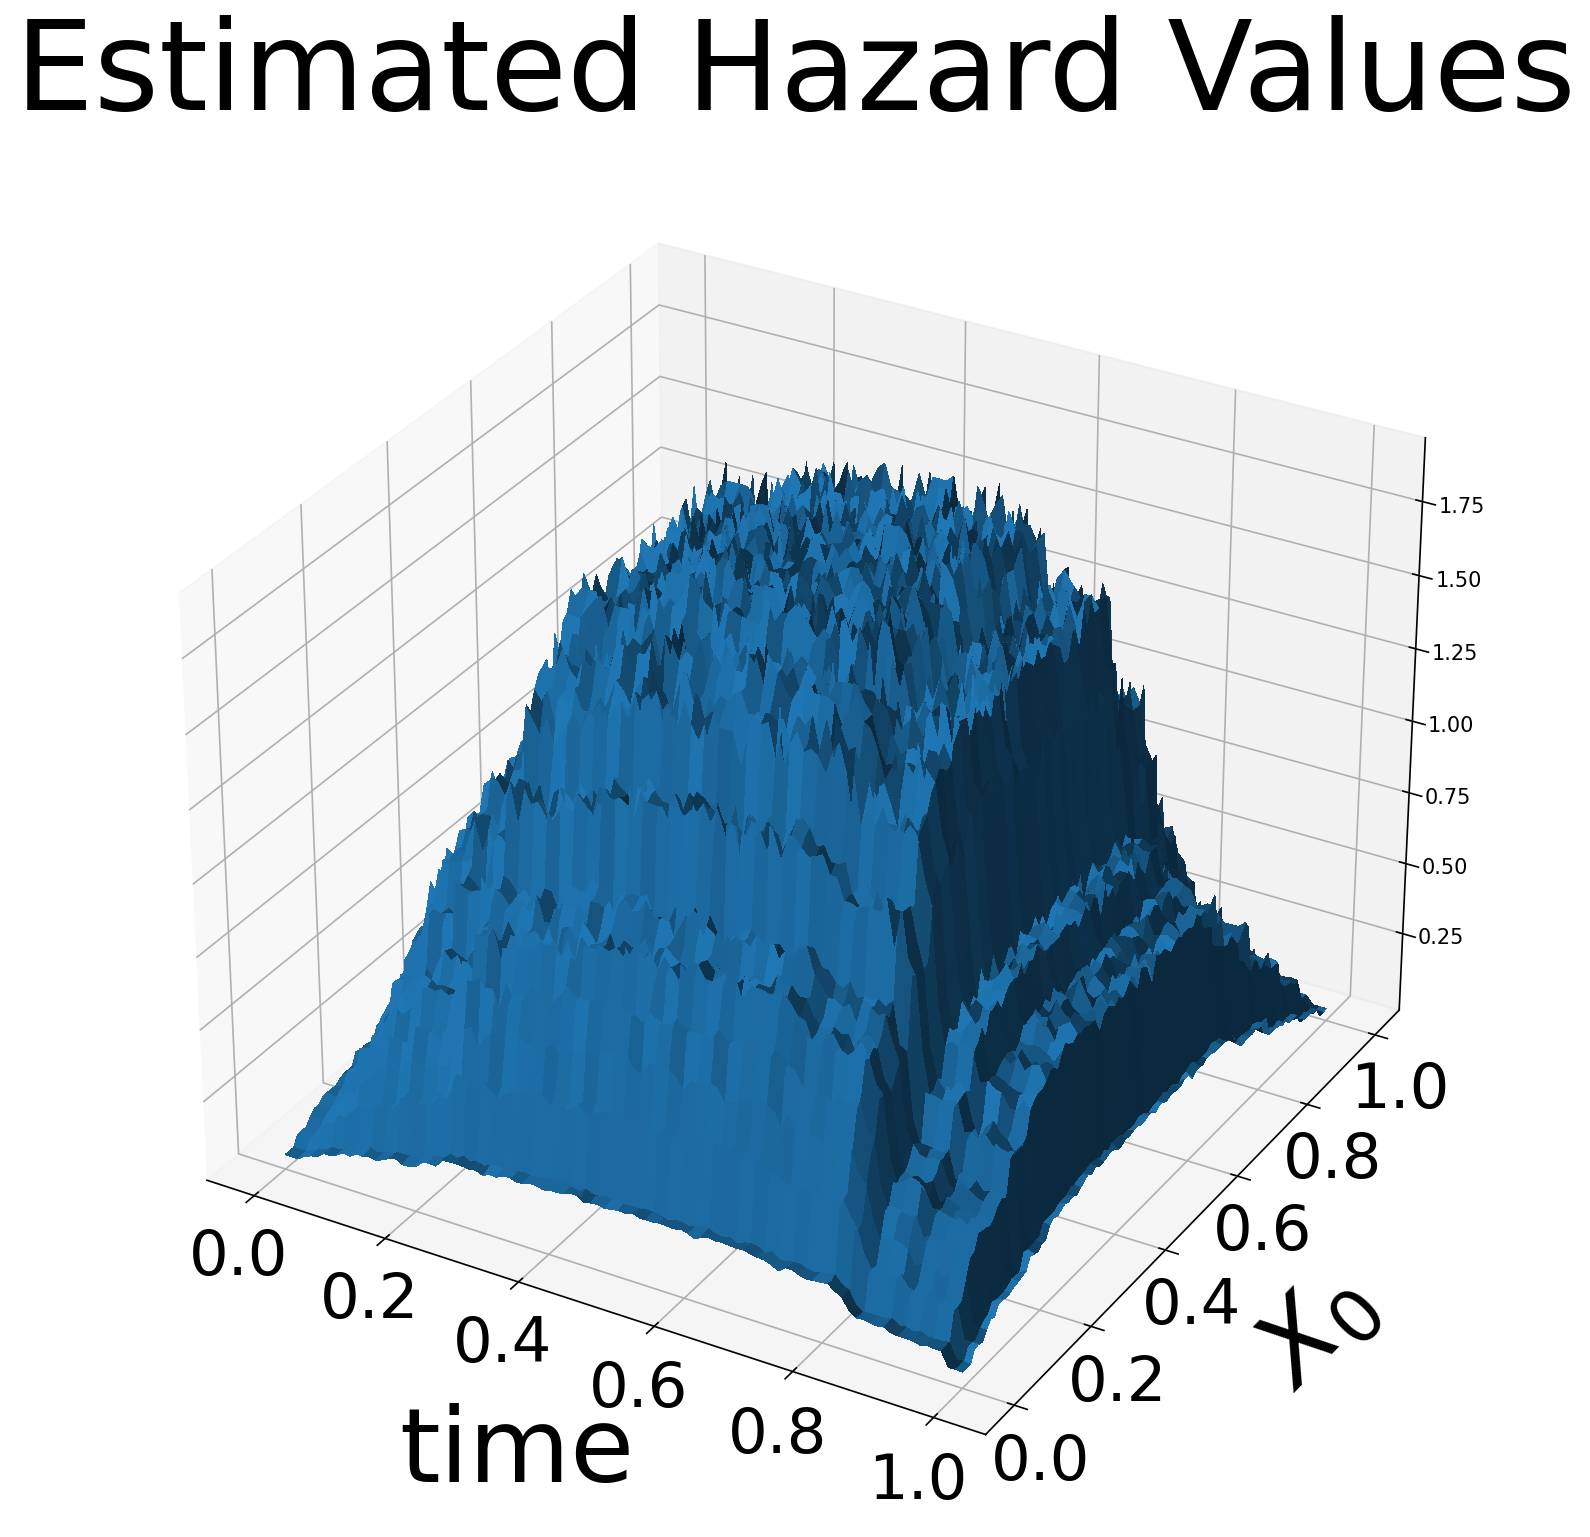

In [10]:
# Estimate the value of the hazard function for each row of the test set
preds = boxhed_.predict(test_X)


import math
import matplotlib.pyplot as plt

figsize  = (12,12)
dpi      = 150
fontsize = 50

fig  = plt.figure(figsize=figsize, dpi=dpi)
ax   = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(*[arr.reshape(*([int(math.sqrt(len(preds)))]*2)) for arr in [test_X['t'].values, test_X['X_0'].values, preds]],
                    linewidth=0, antialiased=False)

plt.title("Estimated Hazard Values", fontsize=fontsize+10)
plt.ylabel(r"$X_0$", fontsize=fontsize, rotation=0, labelpad=30)
plt.xlabel("time",   fontsize=fontsize, rotation=0, labelpad=30)

plt.xticks(fontsize= fontsize-20)
plt.yticks(fontsize= fontsize-20)

plt.show()

## Saving and loading the fitted `BoXHED2.0` estimator
Use `dump_model()` to save the fitted `BoXHED2.0` instance to disk, and use `load_model()` to retrieve it.

#### Input for `dump_model()`:
* `fname`: the name of the file to write to disk. It can be a relative or an absolute path.

#### Input for `load_model()`:
* `fname`: the name of the file containing the stored instance. It can be a relative or an absolute path.

In [11]:
boxhed_.dump_model("./boxhed.pkl")

In [12]:
boxhed_2 = boxhed() #create a new BoXHED instance to load the saved estimator
boxhed_2.load_model("./boxhed.pkl") # after running this line, boxhed_2 is equivalent to boxhed_ fitted above